<span style="font-size:3em">How to impute missing values in Python ?</span> 

If you have a dataset which contains missing values, it is relevant to impute the missing values, mainly for two reasons: (i) these values may be particularly interesting in themselves or (ii) the fully completed data is required to perform some estimation method that does not handle the missing data.

In this section we provide, for some of the main classes and functions in Python (the list is of course not thorough) to impute missing values, links to tutorials if any, as well as a description of their main functionalities and reusable code. The goal is not to describe all the methods precisely, as many resources are already available, but rather to provide an overview of several imputation options. The methods we focus on are gathered in the table below.

| Class (or function)      | Data Types    | Underlying Method   | Imputation | Comments |
| ------------- |:--------------| ------------------- |------------|--------------|
| SingleImputer with strategy='mean' (default)    | quantitative        |imputation by the mean| single| Benchmark method |
| softImpute function    | quantitative  |low-rank matrix completion | single| Strong theoretical guarantees, regularization parameter to tune |
| IterativeImputer with BayesianRidge (default)         | mixed         |imputation by chained equations | single   |  Very flexible to data types, no parameter to tune |
| IterativeImputer with ExtraTreesRegressor    | mixed         |random forests| single| Requires large sample sizes, no parameter to tune |
| Sinkhorn imputation    | quantitative        |optimal transport| single|  |


Both SimpleImputer and IterativeImputer classes come from the module sklearn.impute. The softImpute function has been coded by [Boris Muzellec](https://github.com/BorisMuzellec/MissingDataOT).

In [1]:
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from softimpute import softimpute, cv_softimpute

from sklearn.ensemble import ExtraTreesRegressor

In [2]:
import numpy as np

import pandas as pd

from utils import *
import torch

from produceNA import *

from tools import color_imputedvalues_orange

from itertools import product 

from sklearn.preprocessing import scale

## Description of imputation methods on synthetic data

Let us consider a gaussian data matrix of size $n$ times $p$. 

In [3]:
np.random.seed(0)  # fix the seed 

n = 1000
p = 10

mean = np.repeat(0, p)
cov = 0.5 * (np.ones((p,p)) + np.eye(p))
x_comp = np.random.multivariate_normal(mean, cov, size = n)

In [4]:
pd.DataFrame(x_comp).head()

,0,1,2,3,4,5,6,7,8,9
0,-1.039823,-0.648585,-1.202315,-1.801708,-1.434192,-2.184548,-1.113916,0.045707,-2.809861,-0.893321
1,0.868731,0.210956,-0.805729,-0.218203,-0.546509,0.074347,0.579134,0.184842,-0.736347,-0.679478
2,2.331809,2.469146,2.534037,-0.015830,2.494346,2.247102,2.084273,1.665124,0.726615,2.396857
3,0.138767,-0.804771,-0.299919,-0.237053,-0.774835,0.237507,1.145023,-1.091310,0.509789,0.027682
4,-0.174949,-0.194611,0.977590,1.948265,0.904742,-0.394993,0.118027,1.496719,1.222242,1.873245


We introduce some missing (here MCAR) values in the data matrix using the function `produce_NA` given in the Python Notebook [How to generate missing values in Python ?](https://rmisstastic.netlify.app/how-to/python/generate_html/how%20to%20generate%20missing%20values). 

In [5]:
p = 0.3 #30% of Missing Values

XproduceNA =  produce_NA(x_comp, p_miss=p, mecha="MCAR") #True for missing values, false for others
X_miss = XproduceNA['X_incomp']
x_miss = X_miss.numpy()

In [6]:
Mask = XproduceNA['mask']

In [7]:
pd.DataFrame(x_miss).head().style.highlight_null(null_color='orange')

,0,1,2,3,4,5,6,7,8,9
0,nan,-0.648585,-1.20232,-1.80171,-1.43419,-2.18455,-1.11392,0.0457074,-2.80986,-0.893321
1,0.868731,0.210956,-0.805729,-0.218203,-0.546509,0.0743472,0.579134,nan,-0.736347,-0.679478
2,2.33181,2.46915,2.53404,-0.0158299,2.49435,2.2471,nan,1.66512,nan,2.39686
3,0.138767,nan,-0.299919,nan,-0.774835,0.237507,1.14502,nan,nan,0.0276818
4,-0.174949,-0.194611,0.97759,1.94827,0.904742,-0.394993,0.118027,1.49672,1.22224,1.87325


### Imputation by the mean

The [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) class provides basic strategies for imputing missing values as the mean imputation. This is a naive imputation, which serves as benchmark in the sequel. 

In [8]:
x_mean = SimpleImputer().fit_transform(x_miss)

In [9]:
pd.DataFrame(x_mean).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,0.0603533,-0.648585,-1.20232,-1.80171,-1.43419,-2.18455,-1.11392,0.0457074,-2.80986,-0.893321
1,0.868731,0.210956,-0.805729,-0.218203,-0.546509,0.0743472,0.579134,0.0334493,-0.736347,-0.679478
2,2.33181,2.46915,2.53404,-0.0158299,2.49435,2.2471,0.00420597,1.66512,0.0649096,2.39686
3,0.138767,-0.0205323,-0.299919,-0.046619,-0.774835,0.237507,1.14502,0.0334493,0.0649096,0.0276818
4,-0.174949,-0.194611,0.97759,1.94827,0.904742,-0.394993,0.118027,1.49672,1.22224,1.87325


### softimpute

The function softimpute (original article of [Hastie and al.](http://jmlr.org/papers/volume16/hastie15a/hastie15a.pdf)) can be used to impute quantitative data. It fits a low-rank matrix approximation to a matrix with missing values via nuclear-norm regularization. The main arguments are the following. 

* `X`: the data set with missing values (matrix).

* `lambda`: the nuclear-norm regularization parameter.

To calibrate the parameter lambda, one may perform cross-validation, coded in the function cv_softimpute which takes in argument the data set with missing values and the length of the grid on which cross-validation is performed.

In [10]:
cv_error, grid_lambda = cv_softimpute(x_miss, grid_len=15)
lbda = grid_lambda[np.argmin(cv_error)]
x_soft = softimpute((x_miss), lbda)[1]

In [11]:
pd.DataFrame(x_soft).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,-0.898805,-0.648585,-1.20232,-1.80171,-1.43419,-2.18455,-1.11392,0.0457074,-2.80986,-0.893321
1,0.868731,0.210956,-0.805729,-0.218203,-0.546509,0.0743472,0.579134,-0.145794,-0.736347,-0.679478
2,2.33181,2.46915,2.53404,-0.0158299,2.49435,2.2471,1.32347,1.66512,1.34987,2.39686
3,0.138767,0.0169422,-0.299919,0.0431451,-0.774835,0.237507,1.14502,-0.0464279,0.086953,0.0276818
4,-0.174949,-0.194611,0.97759,1.94827,0.904742,-0.394993,0.118027,1.49672,1.22224,1.87325


### Iterative chained equations

Iterative chained equations methods consist in (iterative) imputation using conditional expectation. The [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) class provides such methods and is inspired by the [mice](https://cran.r-project.org/web/packages/mice/index.html)  package in R but differs from it by returning a single imputation instead of multiple imputations. 

The main arguments are

* `estimator`: the estimator to use for the imputation. By default, it is the BayesianRidge estimator which does a regularized linear regression.

*  `random_state`: maximum number of imputation rounds to perform. (The last imputations are returned.)

*  `max_iter`: seed of the pseudo random number generator to use.

The method fit_transform allows to fit the imputer on the incomplete matrix and return the complete matrix. 

In [12]:
x_ice = IterativeImputer(random_state=0, max_iter=50).fit_transform(x_miss)

In [13]:
pd.DataFrame(x_ice).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,-1.11407,-0.648585,-1.20232,-1.80171,-1.43419,-2.18455,-1.11392,0.0457074,-2.80986,-0.893321
1,0.868731,0.210956,-0.805729,-0.218203,-0.546509,0.0743472,0.579134,-0.276992,-0.736347,-0.679478
2,2.33181,2.46915,2.53404,-0.0158299,2.49435,2.2471,1.80142,1.66512,1.9159,2.39686
3,0.138767,-0.0386615,-0.299919,-0.00576321,-0.774835,0.237507,1.14502,-0.213522,0.253529,0.0276818
4,-0.174949,-0.194611,0.97759,1.94827,0.904742,-0.394993,0.118027,1.49672,1.22224,1.87325


Another estimor can be used, the ExtraTreesRegressor estimator, which trains a random forest on the observed values to predict missing values of a data matrix and mimics the [missForest](https://cran.r-project.org/web/packages/missForest/missForest.pdf) in R. [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor) fits a number of randomized extra-trees and averages the results. It comes from the module sklearn.ensemble. Its main arguments are the number of trees in the forest and the random state which allows to control the sources of randomness. 

In [14]:
estimator_rf = ExtraTreesRegressor(n_estimators=10, random_state=0)
x_rf = IterativeImputer(estimator=estimator_rf, random_state=0, max_iter=50).fit_transform(x_miss)

/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [15]:
pd.DataFrame(x_rf).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,-1.27488,-0.648585,-1.20232,-1.80171,-1.43419,-2.18455,-1.11392,0.0457074,-2.80986,-0.893321
1,0.868731,0.210956,-0.805729,-0.218203,-0.546509,0.0743472,0.579134,-0.251929,-0.736347,-0.679478
2,2.33181,2.46915,2.53404,-0.0158299,2.49435,2.2471,1.67049,1.66512,2.05658,2.39686
3,0.138767,0.251909,-0.299919,0.393735,-0.774835,0.237507,1.14502,0.562764,0.229014,0.0276818
4,-0.174949,-0.194611,0.97759,1.94827,0.904742,-0.394993,0.118027,1.49672,1.22224,1.87325


### Sinkhorn imputation

Sinkhorn imputation can be used to impute quantitative data. It relies on the idea that two batches extracted randomly from the same dataset should share the same distribution and consists in minimizing OT distances between batches. More details can be found in the original [article](https://arxiv.org/pdf/2002.03860.pdf) and the code is provided [here](https://github.com/BorisMuzellec/MissingDataOT).

The main argument are

* `eps`: sinkhorn regularization parameter. If the batch size is larger than half the dataset's size, it will be redefined in the imputation methods.

* `lr` : learning rate

* `batchsize` : size of the batches on which the sinkhorn divergence is evaluated

* `niter`: number of gradient updates for each model within a cycle


To set the regularization, one uses the function `pick_epsilon` which takes a multiple of the median distance.
The method fit_transform allows to fit the imputer on the incomplete matrix and return the complete matrix. 


In [16]:
from imputers import OTimputer

X_true = torch.from_numpy(x_comp).double()

eps = pick_epsilon(X_miss)

sk_imputer = OTimputer(eps=eps, batchsize=128, lr=0.01, niter=15)
sk_imp, _, _ = sk_imputer.fit_transform(X_miss, X_true=X_true)

In [17]:
sk_imp_np = sk_imp.detach().numpy()
pd.DataFrame(sk_imp_np).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,0.136481,-0.648585,-1.20232,-1.80171,-1.43419,-2.18455,-1.11392,0.0457074,-2.80986,-0.893321
1,0.868731,0.210956,-0.805729,-0.218203,-0.546509,0.0743472,0.579134,0.122685,-0.736347,-0.679478
2,2.33181,2.46915,2.53404,-0.0158299,2.49435,2.2471,0.185447,1.66512,0.256406,2.39686
3,0.138767,0.0745942,-0.299919,0.0466183,-0.774835,0.237507,1.14502,0.174301,0.207446,0.0276818
4,-0.174949,-0.194611,0.97759,1.94827,0.904742,-0.394993,0.118027,1.49672,1.22224,1.87325


## Comparison on synthetic data

We compare the methods presented above for different percentage of missing values and for different missing-data mechanisms: 

* Missing Completely At Random (MCAR) if the probability of being missing is the same for all observations

* Missing At Random (MAR) if the probability of being missing only depends on observed values.

* Missing Not At Random (MNAR) if the unavailability of the data depends on both observed and unobserved data such as its value itself.

The cause of missingness shoud be studied before making a choice of imputation method.

We compare the methods in terms of MSE, i.e.:
$$MSE(X^{imp}) = \frac{1}{n_{NA}}\sum_{i}\sum_{j} 1_{X^{NA}_{ij}=NA}(X^{imp}_{ij} - X_{ij})^2$$
where $n_{NA} = \sum_{i}\sum_{j} 1_{X^{NA}_{ij}=NA}$ is the number of missing entries in $X^{NA}$.

Note that in order to evaluate this error, we need to know the true values of the missing entries.

The function **HowToImpute** compares the methods above with the imputation by the mean (the benchmark method). It computes the results (aggregation of the results for several simulations) of the methods for different percentages of missing values and missing-data mechanisms. The arguments are the following. 

* `x_comp`: the complete data set where the missing values will be introduced (numpy array)

* `perc_list`: list containing the different percentage of missing values

* `mecha_list`: list containing the different missing-data mechanisms ("MCAR","MAR" or "MNAR")

* `nbsim`: number of simulations performed


In [18]:
def HowToImpute(x_comp , perc_list , mecha_list , nbsim):
    """
    Compare several imputation methods for different percentages of misisng values and missing-data mechanisms.
    
    Parameters
    ----------
    x_comp : the complete data set where the missing values will be introduced (numpy array).
    perc_list : list containing the different percentage of missing values.
    mecha_list : list containing the different missing-data mechanisms ("MCAR","MAR" or "MNAR").
    nbsim : number of simulations performed.
    
    Returns
    -------
    df: dataframe containing the mean of the results for the simulations performed. 
    """
    mecha_perc_list = pd.DataFrame([(mecha,perc) for mecha, perc in product(mecha_list,perc_list)])
    df = mecha_perc_list.apply(ComparMethods, axis=1, x_comp=x_comp, nbsim=nbsim)
    df.index = mecha_perc_list.apply(lambda x : x[0] + " " + str(x[1]), axis=1)
    
    return df

def ComparMethods(mecha_perc, x_comp, nbsim):
    """
    Compare several imputation methods for a given percentage of misisng values and a given missing-data mechanism.
    
    Parameters
    ----------
    mecha_perc : list containing the missing-data mechanism and the percentage of missing values to be used for introducing missing values. 
    x_comp : the complete data set where the missing values will be introduced (matrix).
    nbsim : number of simulations performed.
    
    Returns
    -------
    
    """
    mecha = mecha_perc[0]
    perc = mecha_perc[1]
    
    RMSE_results = pd.DataFrame()
    Methods = ['mean', 'softimpute', 'ice', 'rf']
    for meth in Methods:
        RMSE_results[meth]=[]
    
    for sim in range(0,nbsim):
        ## Introduction NA
        if mecha == "MAR":
            XproduceNA = produce_NA(x_comp, perc, mecha, p_obs=0.5)
        elif mecha == "MNAR":
            XproduceNA = produce_NA(x_comp, perc, mecha, p_obs=0.5, opt="logistic")
        else: 
            XproduceNA = produce_NA(x_comp, perc, mecha)
        mask = XproduceNA['mask'].numpy()
        x_miss = XproduceNA['X_incomp'].numpy()
        
        ## Mean
        x_mean = SimpleImputer().fit_transform(x_miss)
        rmse_mean = RMSE(x_mean, x_comp, mask)

        ## SoftImpute
        cv_error, grid_lambda = cv_softimpute(x_miss, grid_len=15)
        lbda = grid_lambda[np.argmin(cv_error)]
        x_soft = softimpute((x_miss), lbda)[1]
        rmse_soft = RMSE(x_soft, x_comp, mask)

        ## Ice
        x_ice = IterativeImputer(random_state=0, max_iter=50).fit_transform(x_miss)
        rmse_ice = RMSE(x_ice, x_comp, mask)

        ## Random Forests
        estimator_rf = ExtraTreesRegressor(n_estimators=10, random_state=0)
        x_rf = IterativeImputer(estimator=estimator_rf, random_state=0, max_iter=50).fit_transform(x_miss)
        rmse_rf = RMSE(x_rf, x_comp, mask)
        
        ## Sinkhorn imputation
        X_true = torch.from_numpy(x_comp).double()
        X_miss = XproduceNA['X_incomp']
        batchsize = 128
        lr = 1e-2
        epsilon = pick_epsilon(X_miss)
        sk_imputer = OTimputer(eps=epsilon, batchsize=batchsize, lr=lr, niter=2000)
        sk_imp, _, _ = sk_imputer.fit_transform(X_miss, verbose=True, report_interval=500, X_true=X_true)
        rmse_sk_imp = RMSE(sk_imp.detach().numpy(), x_comp, mask)
    
        new_rmse = {'mean': rmse_mean, 'softimpute': rmse_soft, 'ice': rmse_ice, 'rf': rmse_rf, 'sk': rmse_sk_imp}
        RMSE_results = RMSE_results.append(new_rmse, ignore_index=True)
        
    return RMSE_results.mean()
   

In [19]:
perc_list = [0.2, 0.5, 0.7]
mecha_list = ["MCAR", "MAR", "MNAR"]

results_how_to_impute = HowToImpute(x_comp, perc_list , mecha_list , nbsim=2)

/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reache

In [20]:
results_how_to_impute

,mean,softimpute,ice,rf,sk
MCAR 0.2,0.985053,0.746457,0.734655,0.803710,0.786348
MCAR 0.5,0.993121,0.786427,0.883961,0.872911,0.822149
MCAR 0.7,1.004397,0.839651,0.873855,0.972987,0.865884
MAR 0.2,1.016981,0.736981,0.715243,0.777101,0.761736
MAR 0.5,1.054929,0.778114,0.882901,0.843381,0.778827
MAR 0.7,1.079728,0.783765,0.852871,0.909942,0.788074
MNAR 0.2,1.046733,0.775815,0.753012,0.820059,0.800766
MNAR 0.5,1.032954,0.799544,0.890789,0.880151,0.825589
MNAR 0.7,1.043304,0.827825,0.895798,1.005527,0.872813


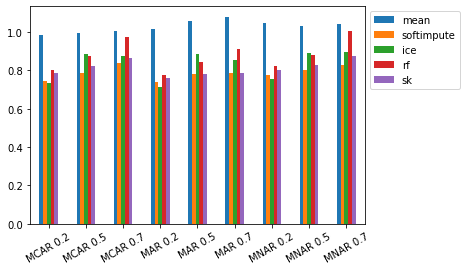

In [21]:
ax = results_how_to_impute.plot(kind="bar",rot=30)
ax.get_legend().set_bbox_to_anchor((1, 1))

## Comparison on real data

We will now compare the methods on real data set taken from the UCI repository [@dua_graff_2019]. In the present workflow, we propose a selection of several data sets readable which can be loaded with `dataset_loader`. The function `dataset_loader` takes as argument the name (str) of the dataset to retrieve.

- Seeds (221x7) 'seeds'
- Wine Quality - Red (1599x11) 'wine_quality_red'
- Wine Quality - White (4898x11) 'wine_quality_white'
- Slump (103x9) 'concrete_slump'

It loads the quantitative variables only.

In [22]:
from data_loaders import * 

In [23]:
don = dataset_loader('wine_quality_red')

You can choose to scale data prior to running the experiments, which implies that the variable have the same weight in the analysis. Scaling data may be performed on complete data sets but is more difficult for incomplete data sets. Let us keep in mind that it is more realistic to not scale data.

In [28]:
scale_data = True
if scale_data:
    x_comp = scale(don)

In [29]:
perc_list = [0.2, 0.5, 0.7]
mecha_list = ["MCAR", "MAR", "MNAR"]

results_how_to_impute = HowToImpute(x_comp, perc_list , mecha_list , nbsim=2)

/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reache

In [30]:
results_how_to_impute

,mean,softimpute,ice,rf,sk
MCAR 0.2,0.994302,0.837539,0.842561,0.699634,0.767826
MCAR 0.5,0.997876,0.902733,0.944179,0.963155,0.909279
MCAR 0.7,0.998531,0.942231,0.983777,1.157877,0.969671
MAR 0.2,1.040756,0.823223,0.779837,0.590097,0.718348
MAR 0.5,1.014092,0.862913,0.948553,0.738932,0.813011
MAR 0.7,0.998892,0.899268,0.928942,0.923761,0.852907
MNAR 0.2,1.027131,0.864803,0.872759,0.736697,0.806251
MNAR 0.5,0.992045,0.890343,0.925549,0.961496,0.878597
MNAR 0.7,0.996551,0.947364,0.980777,1.141866,0.953110


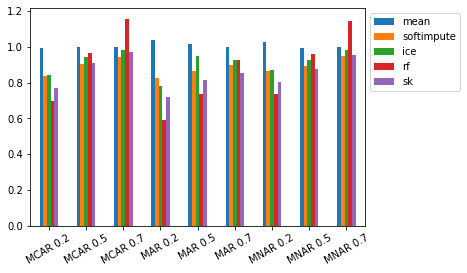

In [31]:
ax = results_how_to_impute.plot(kind="bar",rot=30)
ax.get_legend().set_bbox_to_anchor((1, 1))